In [1]:
%cd ..

/Users/heilman/galvanize/recipe-vectorizer


In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import pymongo
from collections import Counter
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
from networkx.algorithms.community.centrality import girvan_newman
from string import *
from src.functions import *
from src.modeling_functions import *
import imageio
import time
import warnings
warnings.filterwarnings("ignore")

In [3]:
recipes_coll = pymongo.MongoClient()['allrecipes']['recipes']

In [4]:
all_recipes = list(recipes_coll.find())

In [5]:
len(all_recipes)

2570

In [6]:
df = create_dataframe(all_recipes, cutoff=10)

In [7]:
X = df.values
cosine_sims = cosine_similarity(X)

DBSCAN(DB, distFunc, eps, minPts) {
   C = 0                                                  /* Cluster counter */
   for each point P in database DB {
      if label(P) ≠ undefined then continue               /* Previously processed in inner loop */
      Neighbors N = RangeQuery(DB, distFunc, P, eps)      /* Find neighbors */
      if |N| < minPts then {                              /* Density check */
         label(P) = Noise                                 /* Label as Noise */
         continue
      }
      C = C + 1                                           /* next cluster label */
      label(P) = C                                        /* Label initial point */
      Seed set S = N \ {P}                                /* Neighbors to expand */
      for each point Q in S {                             /* Process every seed point */
         if label(Q) = Noise then label(Q) = C            /* Change Noise to border point */
         if label(Q) ≠ undefined then continue            /* Previously processed */
         label(Q) = C                                     /* Label neighbor */
         Neighbors N = RangeQuery(DB, distFunc, Q, eps)   /* Find neighbors */
         if |N| ≥ minPts then {                           /* Density check */
            S = S ∪ N                                     /* Add new neighbors to seed set */
         }
      }
   }
}

In [8]:
def dbscan(similarity_matrix, eps, min_points):
    labels = np.zeros(len(similarity_matrix))
    c = 0
    for i, row in enumerate(similarity_matrix):
        if labels[i] != 0:
            continue
        neighbors = [j for j, sim in enumerate(row) if (sim > eps) and (j != i)]
        if len(neighbors) < min_points:
            labels[i] = -1
            continue
        c += 1
        labels[i] = c
        for j in neighbors:
            if labels[j] == -1:
                labels[j] = c
            if labels[j] != 0:
                continue
            labels[j] = c
            n = [k for k, sim in enumerate(similarity_matrix[j]) if (sim > eps) and (k != j)]
            if len(n) >= min_points:
                for point in n:
                    if point not in neighbors:
                        neighbors.append(point)
    return labels

In [55]:
Counter(labels)

Counter({-1.0: 243, 3.0: 11, 1.0: 12, 2.0: 23, 4.0: 7})

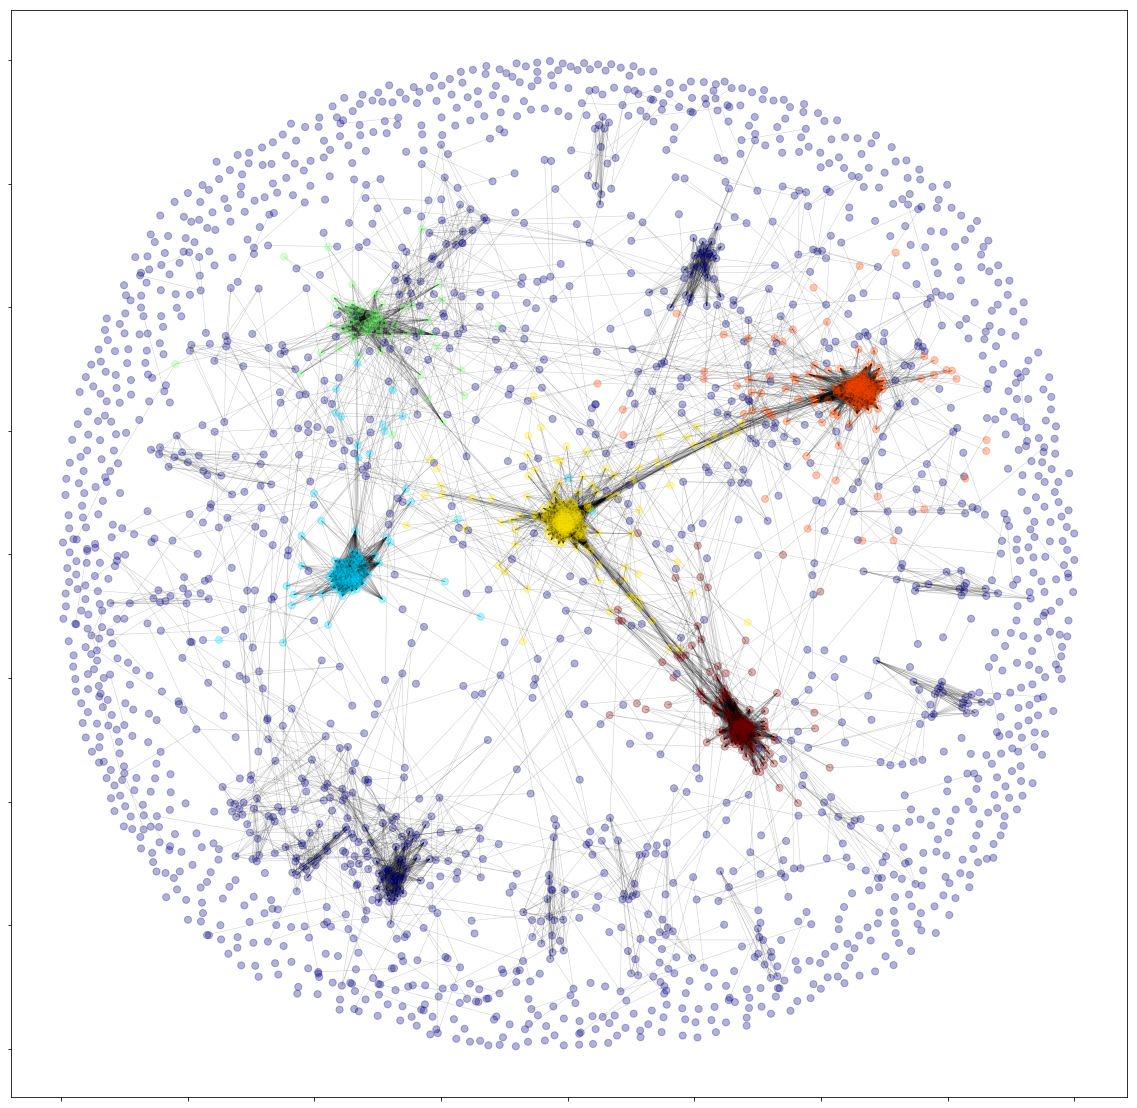

In [22]:
threshold = 0.85
min_points = 45
G = nx.Graph()
labels = dbscan(cosine_sims, threshold, min_points) 
for i in range(len(X)):
    G.add_node(i)
for i, row in enumerate(cosine_sims):
    for j in range(i+1, len(cosine_sims)):
        if cosine_sims[i,j] > threshold:
            G.add_edge(i, j, weight=100*cosine_sims[i,j])

node_colors = [cm.jet((label+1)/(max(labels)+1)) for label in labels]
spring = nx.spring_layout(G, k=0.5, weight='weight', seed=427)
fig, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx_nodes(G,
                       pos=spring,
                       node_size=50,
                       node_color=node_colors,
                       ax=ax,
                       alpha=0.3,
                       with_labels=False)
nx.draw_networkx_edges(G,
                       pos=spring,
                       edge_color='k',
                       width=0.5,
                       alpha=0.2)
ax.set_yticklabels([])
ax.set_xticklabels([]);

In [30]:
nodes = [i for i, label in enumerate(labels) if label == -1]
find_keywords(get_recipe_names(nodes, df.index, all_recipes))

[('soup', 283),
 ('chili', 240),
 ('thai', 196),
 ('chowder', 179),
 ('chicken', 169),
 ('cheese', 143),
 ('sauce', 138),
 ('curry', 115),
 ('stew', 79),
 ('potato', 77)]

In [19]:
def plot_dbscan(ax, cosine_sims, threshold, min_points):
    G = nx.Graph()
    labels = dbscan(cosine_sims, threshold, min_points) 
    for i in range(len(X)):
        G.add_node(i)
    for i, row in enumerate(cosine_sims):
        for j in range(i+1, len(cosine_sims)):
            if cosine_sims[i,j] > threshold:
                G.add_edge(i, j, weight=100*cosine_sims[i,j])

    node_colors = [cm.jet((label+1)/(max(labels)+1)) for label in labels]
    spring = nx.spring_layout(G, k=0.5, weight='weight', seed=427)
    nx.draw_networkx_nodes(G,
                           pos=spring,
                           node_size=50,
                           node_color=node_colors,
                           ax=ax,
                           alpha=0.3,
                           with_labels=False)
    nx.draw_networkx_edges(G,
                           pos=spring,
                           edge_color='k',
                           width=0.5,
                           alpha=0.2)
    
    ax.text(-1.05, 1,'Threshold : {0:4.2}'.format(threshold), fontsize=15)
    ax.text(-1.05, .9,'Min. points : {}'.format(int(min_points)), fontsize=15)
    ax.text(-1.05, .8,'Clusters : {}'.format(int(max(labels))), fontsize=15)
    ax.set_xlim(left=-1.1, right = 1.1)
    ax.set_ylim(bottom=-1.1, top = 1.1)
    ax.set_yticklabels([])
    ax.set_xticklabels([]);

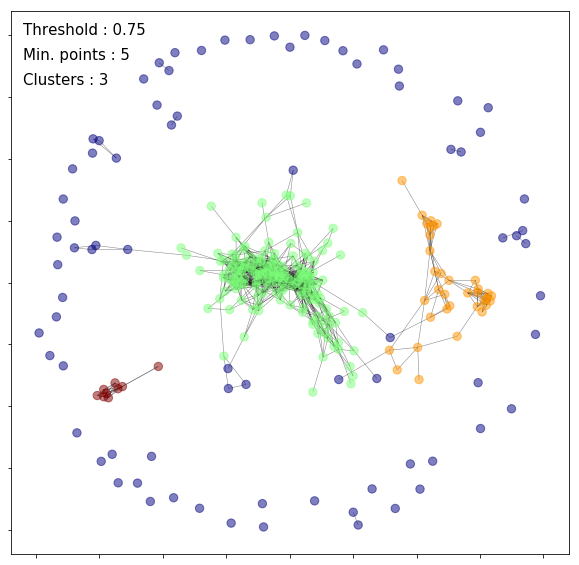

In [161]:
fig, ax = plt.subplots(figsize=(10,10))
plot_dbscan(ax, cosine_sims, 0.75, 5)

### Threshold Sweep

In [33]:
n=15
min_points = 10
figsize=(20,20)
repeats = 3
duration = 1

frames = []
print('0%       10%       20%       30%       40%       50%       60%       70%       80%       90%       100%')
print('|_________|_________|_________|_________|_________|_________|_________|_________|_________|_________|')
for i, thresh in enumerate(np.linspace(.7,.98, n)):
    pct = int((i/n) * 100)
    print('|{0}{1}| {2}% complete'.format('='*pct, '.'*(99-pct),pct), end='\r')
    fig, ax = plt.subplots(figsize=figsize)
    plot_dbscan(ax, cosine_sims, thresh, min_points)
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    frames.append(img)
    if i==0 or i==n-1:
        for _ in range(repeats):
            frames.append(img)
    pct = int(((i+1)/n) * 100)
    s = '='*pct if pct != 100 else '='*99
    print('|{0}{1}| {2}% complete'.format(s, '.'*(99-pct),pct), end='\r')
    
imageio.mimsave('images/dbscan-all-threshold-sweep-mp{}.gif'.format(min_points), frames, duration=duration)


0%       10%       20%       30%       40%       50%       60%       70%       80%       90%       100%
|_________|_________|_________|_________|_________|_________|_________|_________|_________|_________|


### min_points sweep

In [32]:
n=13
threshold = 0.75
figsize=(20,20)
repeats = 3
duration = 2

frames = []
print('0%       10%       20%       30%       40%       50%       60%       70%       80%       90%       100%')
print('|_________|_________|_________|_________|_________|_________|_________|_________|_________|_________|')
for i, min_points in enumerate(np.linspace(30,150, n)):
    pct = int((i/n) * 100)
    print('|{0}{1}| {2}% complete'.format('='*pct, '.'*(99-pct),pct), end='\r')
    fig, ax = plt.subplots(figsize=figsize)
    plot_dbscan(ax, cosine_sims, threshold, min_points)
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    frames.append(img)
    if i==0 or i==n-1:
        for _ in range(repeats):
            frames.append(img)
    pct = int(((i+1)/n) * 100)
    s = '='*pct if pct != 100 else '='*99
    print('|{0}{1}| {2}% complete'.format(s, '.'*(99-pct),pct), end='\r')
    
imageio.mimsave('images/dbscan-all-minpoints-sweep_t75.gif', frames, duration=duration)

0%       10%       20%       30%       40%       50%       60%       70%       80%       90%       100%
|_________|_________|_________|_________|_________|_________|_________|_________|_________|_________|


### Adaptive DBSCAN

#### Start with low min_points, low threshold

#### Save small clusters and remove from pool

#### Increase min_points until large clusters split

#### Attempt to split subclusters individually by lowering min_points

#### Continue to separate and split recursively, stopping when each cluster fails to split